# Data Processor Notebook

This notebook demonstrates how to load and process the MATH-500 dataset and toy tasks for reasoning experiments.

In [3]:
import sys
sys.path.append('../pipeline')

from data_processor import DataProcessor
from transformers import AutoTokenizer

/home/sramishe/.venv llm-env/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sramishe/.venv llm-env/lib64/python3.9/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [4]:
import os
os.environ["TRANSFORMERS_CACHE"] = "/scratch/gilbreth/sramishe"

## Initialize Data Processor

In [5]:
processor = DataProcessor(
    dataset_name="HuggingFaceH4/MATH-500",
    include_toy_tasks=True
)

## Load MATH-500 Dataset

In [6]:
dataset = processor.load_dataset(split="test", max_samples=10)

print(f"Loaded {len(dataset)} examples")
print("\nFirst example:")
print(dataset[0])

Loading dataset: HuggingFaceH4/MATH-500
Loaded 10 examples

First example:
{'problem': 'Convert the point $(0,3)$ in rectangular coordinates to polar coordinates.  Enter your answer in the form $(r,\\theta),$ where $r > 0$ and $0 \\le \\theta < 2 \\pi.$', 'solution': 'We have that $r = \\sqrt{0^2 + 3^2} = 3.$  Also, if we draw the line connecting the origin and $(0,3),$ this line makes an angle of $\\frac{\\pi}{2}$ with the positive $x$-axis.\n\n[asy]\nunitsize(0.8 cm);\n\ndraw((-0.5,0)--(3.5,0));\ndraw((0,-0.5)--(0,3.5));\ndraw(arc((0,0),3,0,90),red,Arrow(6));\n\ndot((0,3), red);\nlabel("$(0,3)$", (0,3), W);\ndot((3,0), red);\n[/asy]\n\nTherefore, the polar coordinates are $\\boxed{\\left( 3, \\frac{\\pi}{2} \\right)}.$', 'answer': '\\left( 3, \\frac{\\pi}{2} \\right)', 'subject': 'Precalculus', 'level': 2, 'unique_id': 'test/precalculus/807.json'}


## Get Toy Tasks

In [7]:
toy_tasks = processor.get_toy_tasks()

print(f"Number of toy tasks: {len(toy_tasks)}")
print("\nToy tasks:")
for i, task in enumerate(toy_tasks, 1):
    print(f"{i}. {task['problem']} → {task['answer']}")

Number of toy tasks: 4

Toy tasks:
1. What is 2+2? → 4
2. What is 10-5? → 5
3. Is 7 a prime number? → Yes
4. What is the square root of 16? → 4


## Format Prompts with Chat Template

In [8]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("Qwen/QwQ-32B-Preview")

# Format a single prompt
test_problem = "What is 2+2?"
formatted_prompt = processor.format_prompt(test_problem, tokenizer)

print("Formatted prompt:")
print(formatted_prompt)

Formatted prompt:
<|im_start|>system
You are a helpful and harmless assistant. You are Qwen developed by Alibaba. You should think step-by-step.<|im_end|>
<|im_start|>user
What is 2+2?<|im_end|>
<|im_start|>assistant



## Prepare Batch of Prompts

In [9]:
# Combine dataset examples and toy tasks
all_examples = dataset[:5] + toy_tasks[:3]

# Prepare batch
prompts = processor.prepare_batch(
    all_examples,
    tokenizer,
    problem_key='problem'
)

print(f"Prepared {len(prompts)} prompts")
print("\nFirst prompt:")
print(prompts[0])

Prepared 8 prompts

First prompt:
<|im_start|>system
You are a helpful and harmless assistant. You are Qwen developed by Alibaba. You should think step-by-step.<|im_end|>
<|im_start|>user
Convert the point $(0,3)$ in rectangular coordinates to polar coordinates.  Enter your answer in the form $(r,\theta),$ where $r > 0$ and $0 \le \theta < 2 \pi.$<|im_end|>
<|im_start|>assistant



## Analyze Dataset Statistics

In [ ]:
#!pip install matplotlib

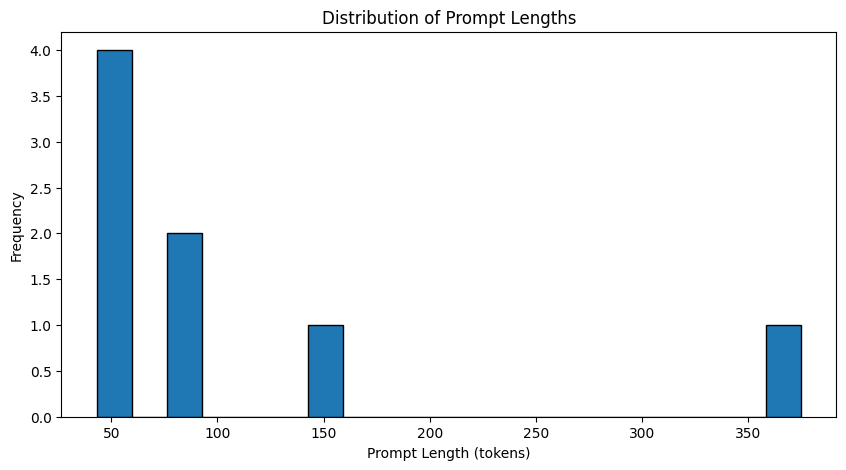

Average prompt length: 108.4 tokens
Max prompt length: 375 tokens
Min prompt length: 43 tokens


In [12]:
import matplotlib.pyplot as plt

# Analyze prompt lengths
prompt_lengths = [len(tokenizer.encode(p)) for p in prompts]

plt.figure(figsize=(10, 5))
plt.hist(prompt_lengths, bins=20, edgecolor='black')
plt.xlabel('Prompt Length (tokens)')
plt.ylabel('Frequency')
plt.title('Distribution of Prompt Lengths')
plt.show()

print(f"Average prompt length: {sum(prompt_lengths)/len(prompt_lengths):.1f} tokens")
print(f"Max prompt length: {max(prompt_lengths)} tokens")
print(f"Min prompt length: {min(prompt_lengths)} tokens")